In [2]:
#%pip install hdbscan -q

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets as data
import hdbscan
from matplotlib.patches import Circle, Rectangle, FancyArrowPatch
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist
%matplotlib inline

In [4]:
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 120, 'linewidths':0}

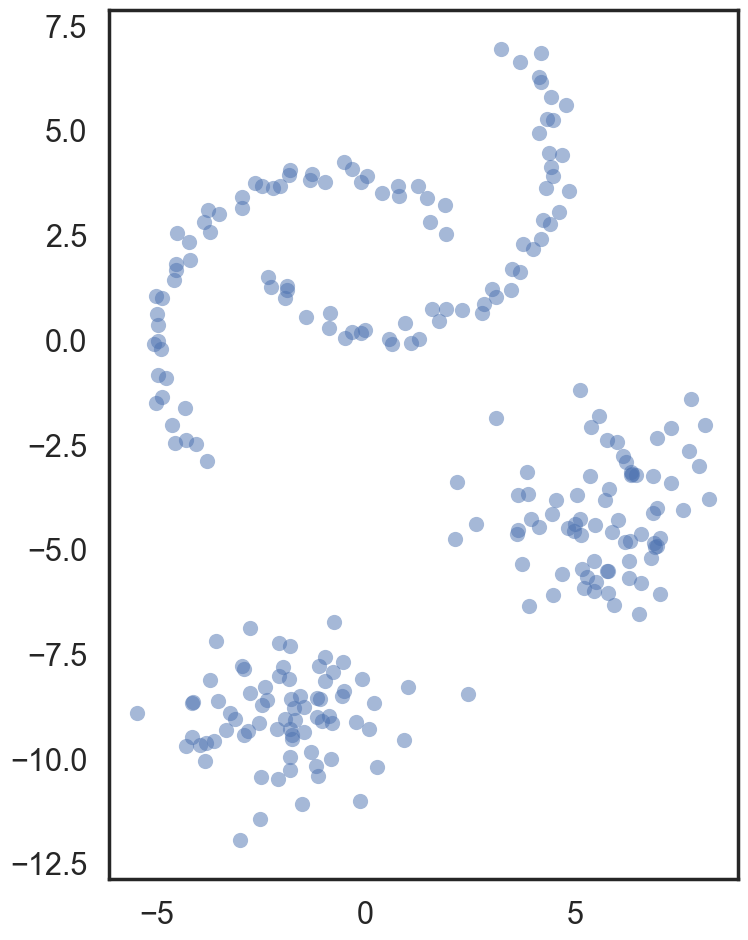

In [ ]:
moons_1, _ = data.make_moons(n_samples=100, noise=0.045, random_state= 42)
blobs_1, _ = data.make_blobs(n_samples=150, cluster_std=1.25, random_state=40, centers = 2)
scale = 4.0 # phóng to
theta = 0.75 # góc xoay (radians), để 0 nếu không muốn xoay
R = np.array([[np.cos(theta), -np.sin(theta)],
              [np.sin(theta),  np.cos(theta)]])
moons_transformed = moons_1.dot(R.T) * scale + np.array([-1.0, 0.0])  # dịch sang trái 3 đơn vị
test_data = np.vstack([moons_transformed, blobs_1])
fig, ax = plt.subplots(figsize=(8, 15))
ax.scatter(test_data[:, 0], test_data[:, 1], color='b', **plot_kwds)
ax.set_aspect("equal", adjustable="box")

plt.tight_layout()
plt.show()

Số điểm trong vùng chọn: 69
Các chỉ số điểm nằm trong vùng: [104 105 107 110 114 116 122 132 137 140 141 142 144 145 148 149 150 151
 153 156 157 159 160 161 164 165 166 168 169 172 173 177 179 180 182 187
 188 190 191 192 195 196 197 198 201 202 204 205 206 213 215 217 218 222
 224 226 227 228 229 231 232 234 237 238 239 240 241 247 249]
Point idx=224: core_k=1.3767 -> nằm trong vùng? có
Point idx=168: core_k=0.7661 -> nằm trong vùng? có
Point idx=157: core_k=1.1946 -> nằm trong vùng? có


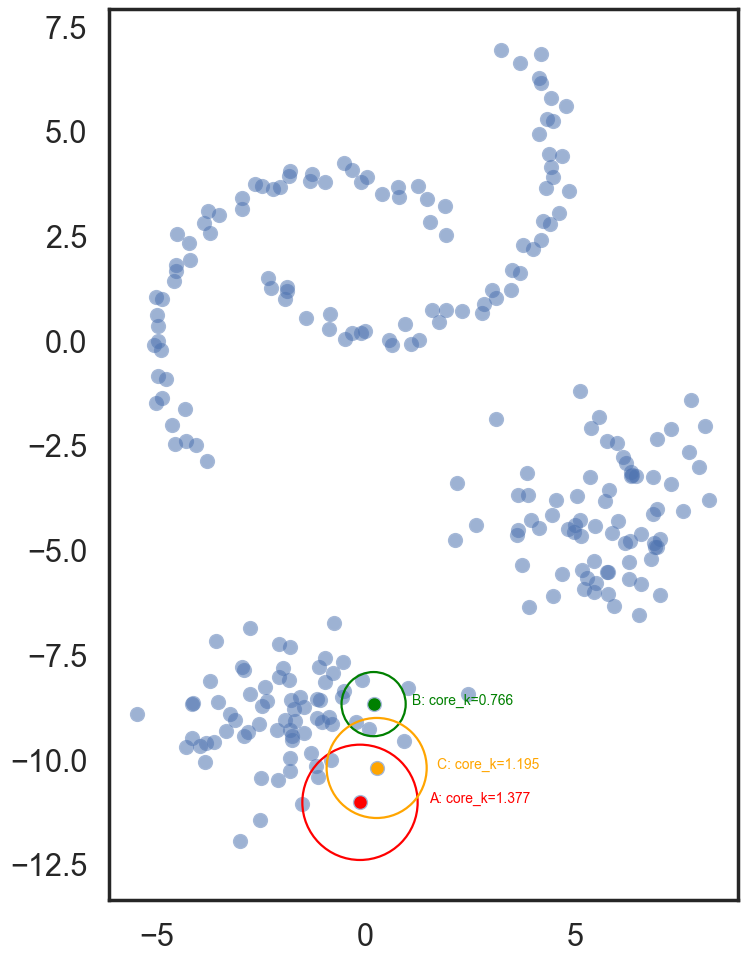

In [100]:
# Tính core distance và ma trận mutual reachability
k = 5
nbrs = NearestNeighbors(n_neighbors=k + 1).fit(test_data)
distances, indices = nbrs.kneighbors(test_data)
core_distances = distances[:, -1]

pairwise = cdist(test_data, test_data, metric="euclidean")
core_matrix = np.maximum.outer(core_distances, core_distances)
mreach_dist = np.maximum.outer(core_distances, core_distances)
mreach_dist = np.maximum(mreach_dist, pairwise)

# Đổi tên các điểm minh họa thành a, b, c
a, b, c = 224, 168, 157
chosen = [a, b, c]

# Màu đồng bộ cho từng điểm
colors = {a: "red", b: "green", c: "orange"}
labels = {a: "A", b: "B", c: "C"}

# Vùng muốn phóng to (xmin, xmax) và (ymin, ymax)
region_x = (-4, 2.0)
region_y = (-12.0, -5.0)

# Tạo mask và subset cho vùng đã khoanh
mask = (
    (test_data[:, 0] >= region_x[0])
    & (test_data[:, 0] <= region_x[1])
    & (test_data[:, 1] >= region_y[0])
    & (test_data[:, 1] <= region_y[1])
)
subset = test_data[mask]
subset_indices = np.where(mask)[0]

# In thông tin nhanh
print(f"Số điểm trong vùng chọn: {len(subset)}")
print("Các chỉ số điểm nằm trong vùng:", subset_indices)
for idx in chosen:
    inside = "có" if mask[idx] else "không"
    print(f"Point idx={idx}: core_k={core_distances[idx]:.4f} -> nằm trong vùng? {inside}")


def draw_point_with_core(ax, idx, label=None):
    """Vẽ điểm và vòng core_k lên trục ax.

    Tham số:
    ax: matplotlib.axes.Axes nơi vẽ
    idx: chỉ số điểm trong test_data
    label: (tuỳ chọn) chuỗi nhãn để in gần điểm
    """
    x, y = test_data[idx]
    r = core_distances[idx]
    col = colors.get(idx, "k")
    ax.plot(x, y, marker="o", markersize=8, color=col)
    circle = Circle((x, y), r, fill=False, linewidth=1.6, edgecolor=col)
    ax.add_patch(circle)
    text = f"" if label is None else f"{label}: core_k={r:.3f}"
    ax.text(x + 1.2 * r, y, text, fontsize=10, color=col)


# biểu đồ toàn bộ dữ liệu + vẽ điểm a, b, c kèm vòng core
plt.figure(figsize=(8, 15))
ax_main = plt.gca()

# Vẽ toàn bộ dữ liệu làm background (mờ)
ax_main.scatter(test_data[:, 0], test_data[:, 1], color="b", alpha=0.08, s=80, linewidths=0)

# Vẽ toàn bộ dữ liệu rõ hơn để làm context (dùng plot_kwds)
ax_main.scatter(test_data[:, 0], test_data[:, 1], color="b", **plot_kwds)

# Vẽ các điểm a, b, c với màu đã định và vòng core
draw_point_with_core(ax_main, a, label="A")
draw_point_with_core(ax_main, b, label="B")
draw_point_with_core(ax_main, c, label="C")
ax_main.set_aspect("equal")
plt.tight_layout()
plt.show()

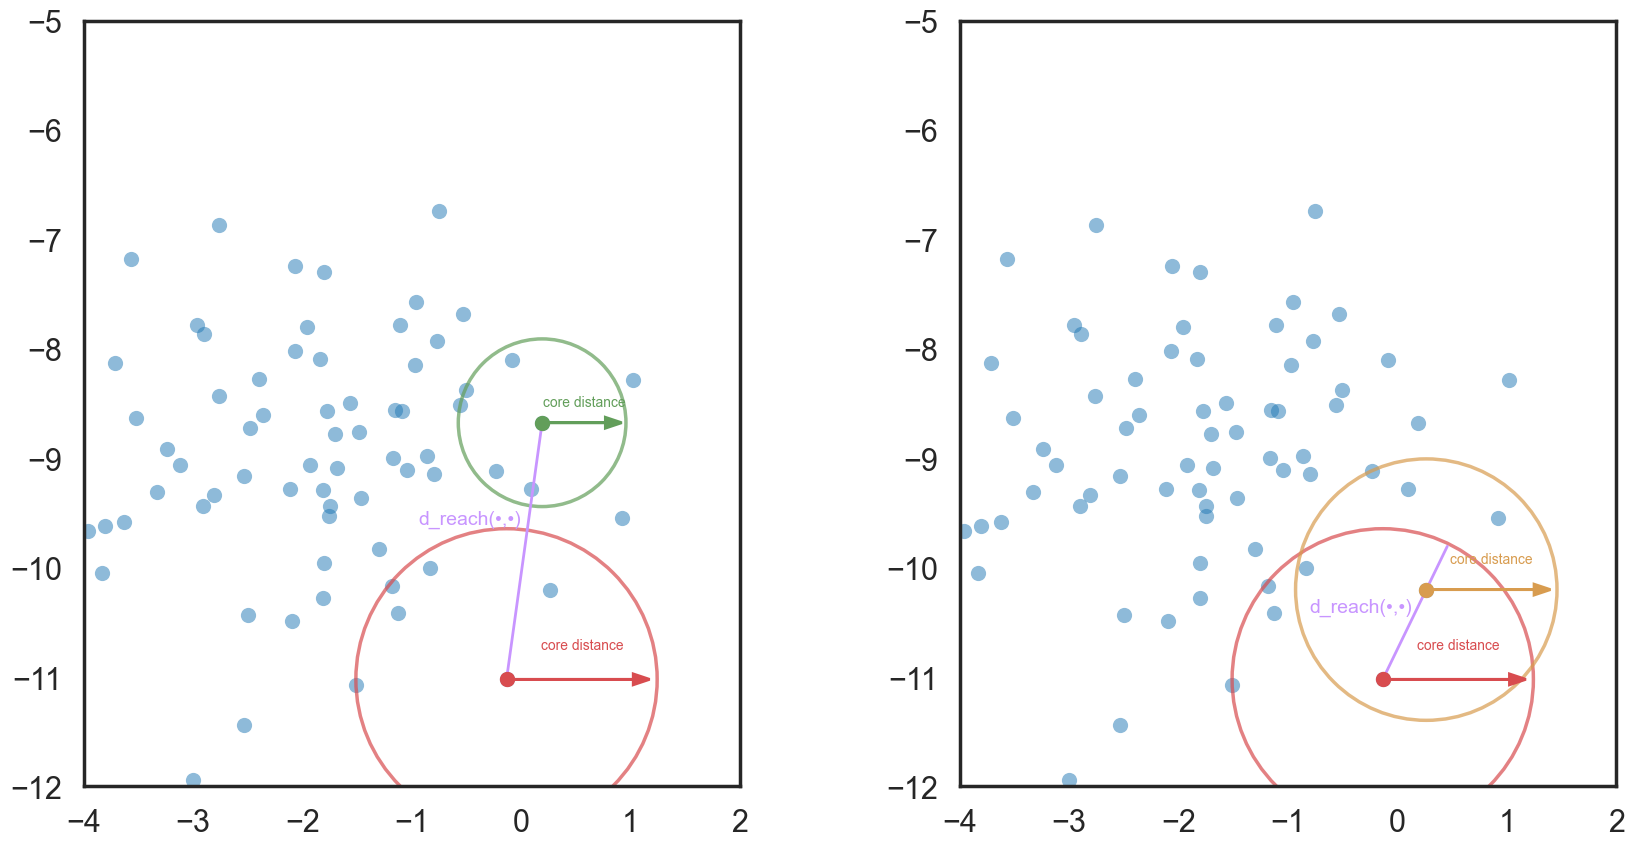

In [101]:
def draw_hdbscan_illustration(ax, p_i, p_j, subset):
    """Vẽ minh họa d_mreach trong một vùng đã được phóng to."""
    color_i, color_j = '#d84c4f', '#629e5a' # Đỏ và Xanh lá
    if p_j == c: # Đổi màu cho điểm C
        color_j = '#d89c4f' # Cam

    pos_i, pos_j = test_data[p_i], test_data[p_j]
    core_i, core_j = core_distances[p_i], core_distances[p_j]
    dist_ij = pairwise[p_i, p_j]
    mreach_ij = mreach_dist[p_i, p_j]

    # Vẽ các điểm nền (chỉ các điểm trong subset)
    ax.scatter(subset[:, 0], subset[:, 1], **plot_kwds)

    # Vẽ hai điểm chính
    ax.plot(pos_i[0], pos_i[1], 'o', c=color_i, markersize=10)
    ax.plot(pos_j[0], pos_j[1], 'o', c=color_j, markersize=10)

    # Vẽ vòng core distance
    circle_i = Circle(pos_i, core_i, ec=color_i, fc='none', lw=2.5, alpha=0.7)
    circle_j = Circle(pos_j, core_j, ec=color_j, fc='none', lw=2.5, alpha=0.7)
    ax.add_patch(circle_i)
    ax.add_patch(circle_j)

    # Vẽ mũi tên chú thích "core distance"
    ax.arrow(pos_i[0], pos_i[1], core_i * 0.95, 0,
             head_width=0.1, head_length=0.15, fc=color_i, ec=color_i, length_includes_head=True)
    ax.text(pos_i[0] + core_i / 2, pos_i[1] + core_i * 0.2, 'core distance', c=color_i, ha='center', fontsize = 10)
    
    ax.arrow(pos_j[0], pos_j[1], core_j * 0.95, 0,
             head_width=0.1, head_length=0.15, fc=color_j, ec=color_j, length_includes_head=True)
    ax.text(pos_j[0] + core_j / 2, pos_j[1] + core_j * 0.2, 'core distance', c=color_j, ha='center', fontsize = 10)

    # Vector từ i đến j
    vec = pos_j - pos_i
    unit_vec = vec / np.linalg.norm(vec)

    # Trường hợp 1: d_mreach bằng khoảng cách thực tế
    if np.isclose(mreach_ij, dist_ij):
        arrow_color = '#C895FF'
        arrow = FancyArrowPatch(pos_i, pos_j, connectionstyle="arc3", arrowstyle='-',
                                mutation_scale=20, lw=2, color=arrow_color)
        ax.add_patch(arrow)
        mid_point = pos_i + vec * 0.5
        ax.text(mid_point[0] - 0.5, mid_point[1] + 0.25, 'd_reach(•,•)',
                color=arrow_color, ha='center', fontsize=14)
    
    # Trường hợp 2: d_mreach bị "kéo dãn"
    else:
        arrow_color = "#C895FF"
        end_point = pos_i + unit_vec * mreach_ij
        arrow = FancyArrowPatch(pos_i, end_point, arrowstyle='-', mutation_scale=20,
                                lw=2, color=arrow_color)
        ax.add_patch(arrow)
        mid_point = pos_i + unit_vec * mreach_ij * 0.5
        ax.text(mid_point[0] - 0.5, mid_point[1], 'd_reach(•,•)',
                color=arrow_color, ha='center', fontsize=14)

    ax.set_aspect('equal')
    ax.set_xlim(region_x)
    ax.set_ylim(region_y)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))
draw_hdbscan_illustration(ax1, a, b, subset)

draw_hdbscan_illustration(ax2, a, c, subset)

plt.tight_layout()
plt.show()

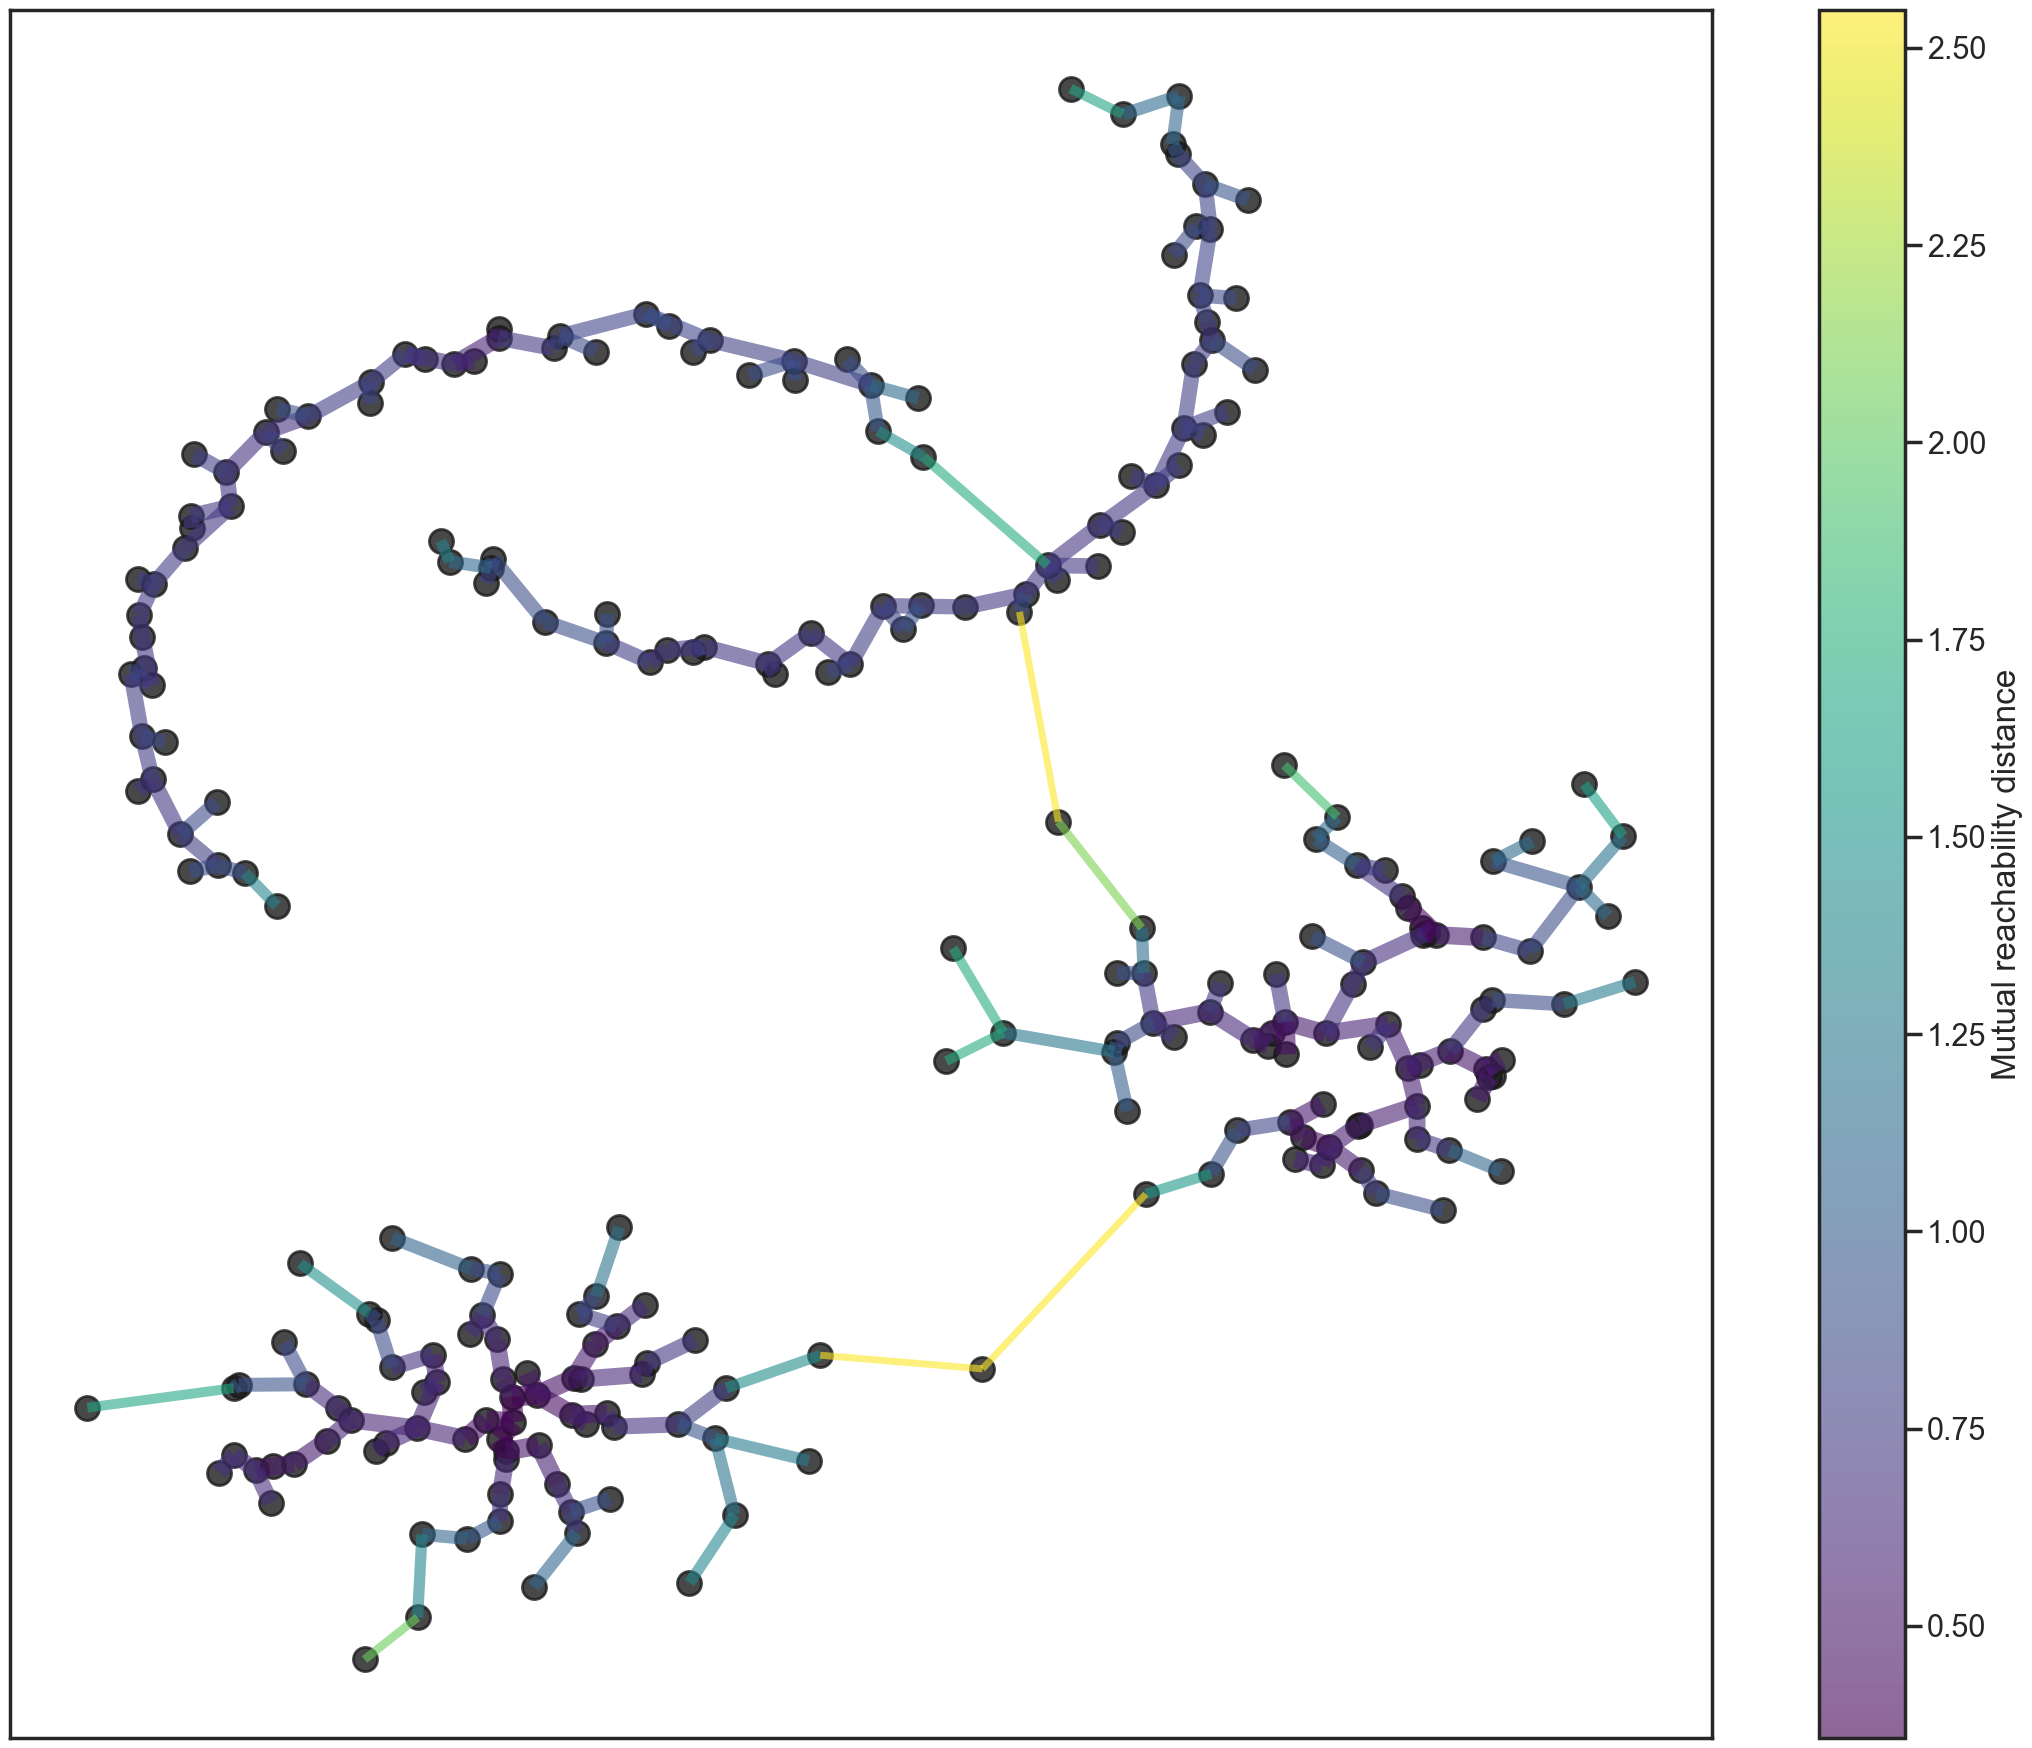

In [102]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
clusterer.fit(test_data)

fig, ax = plt.subplots(figsize=(22, 18))
clusterer.minimum_spanning_tree_.plot(
    edge_cmap='viridis',
    edge_alpha=0.6,
    node_size=300,
    edge_linewidth=5,
)

plt.tight_layout()
plt.show()

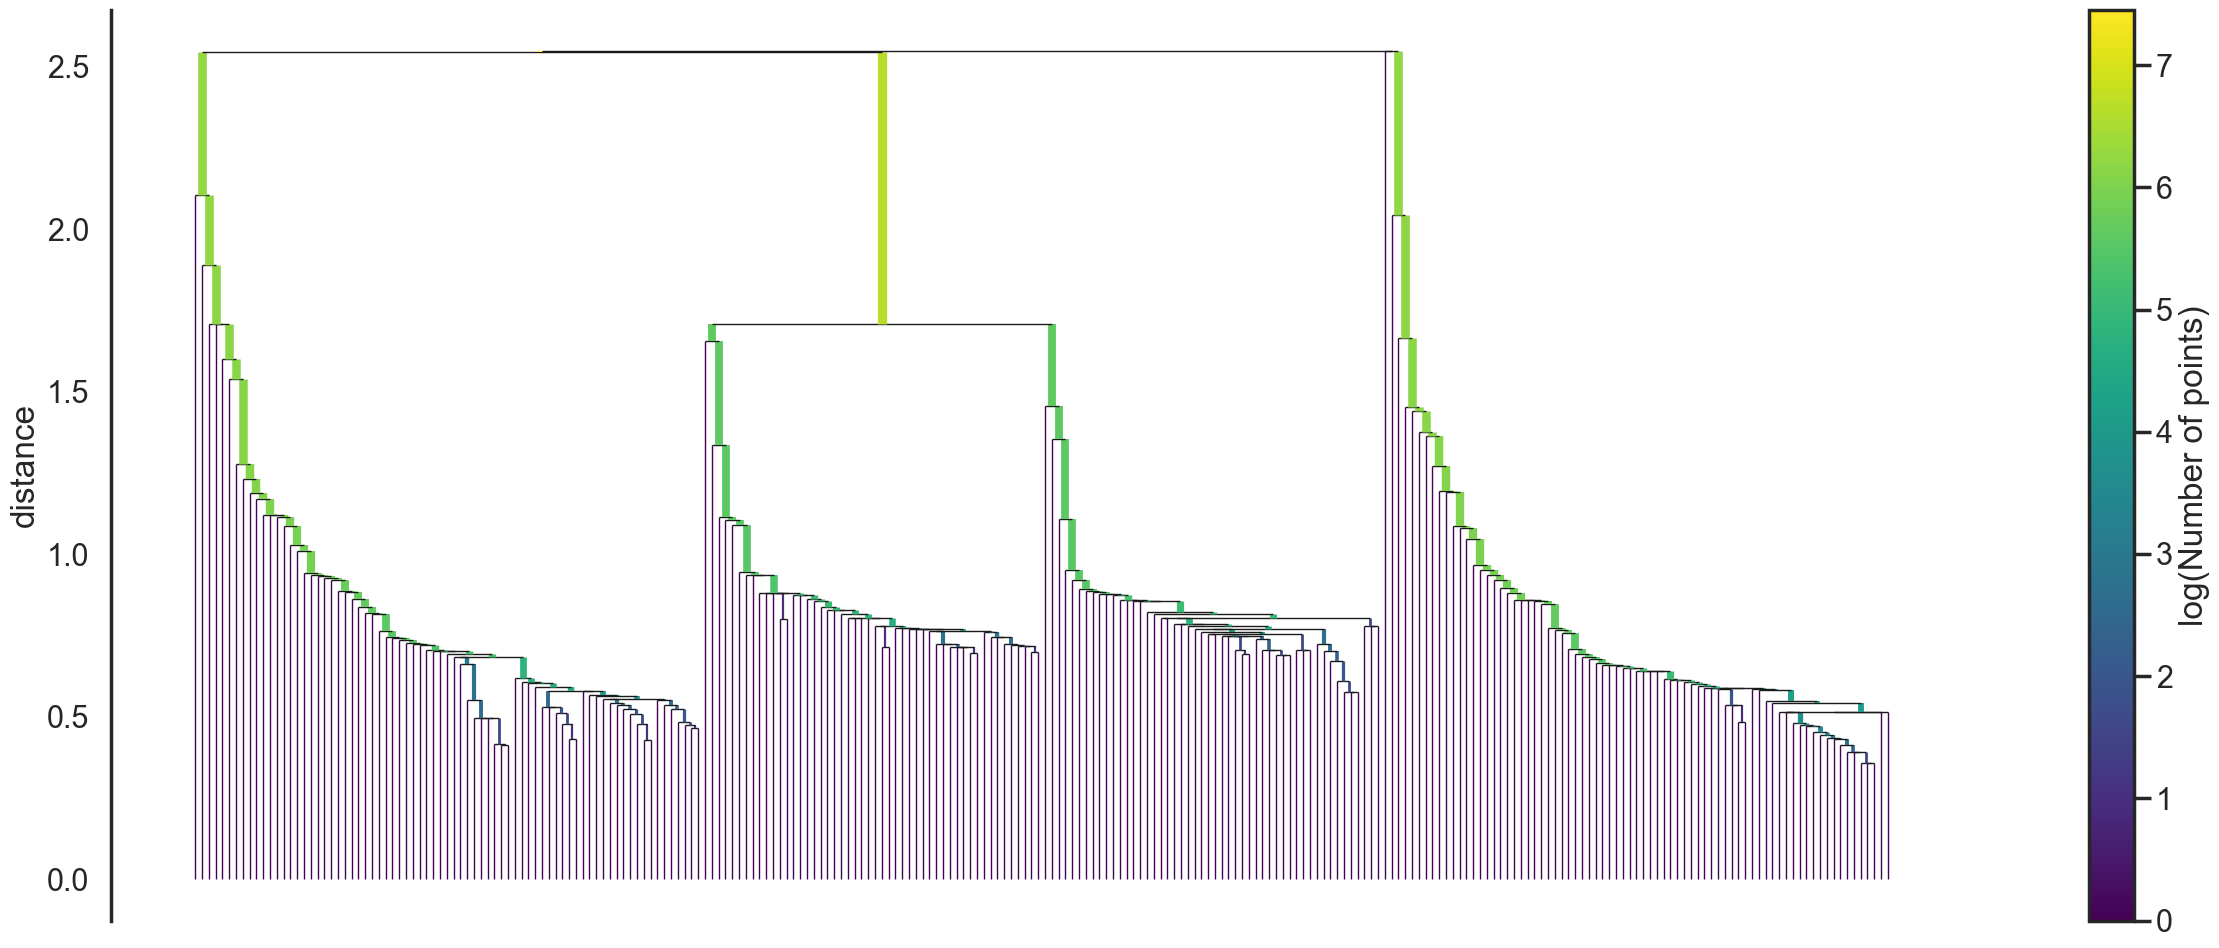

In [103]:
fig, ax = plt.subplots(figsize=(25, 10))
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)
plt.tight_layout()
plt.show()


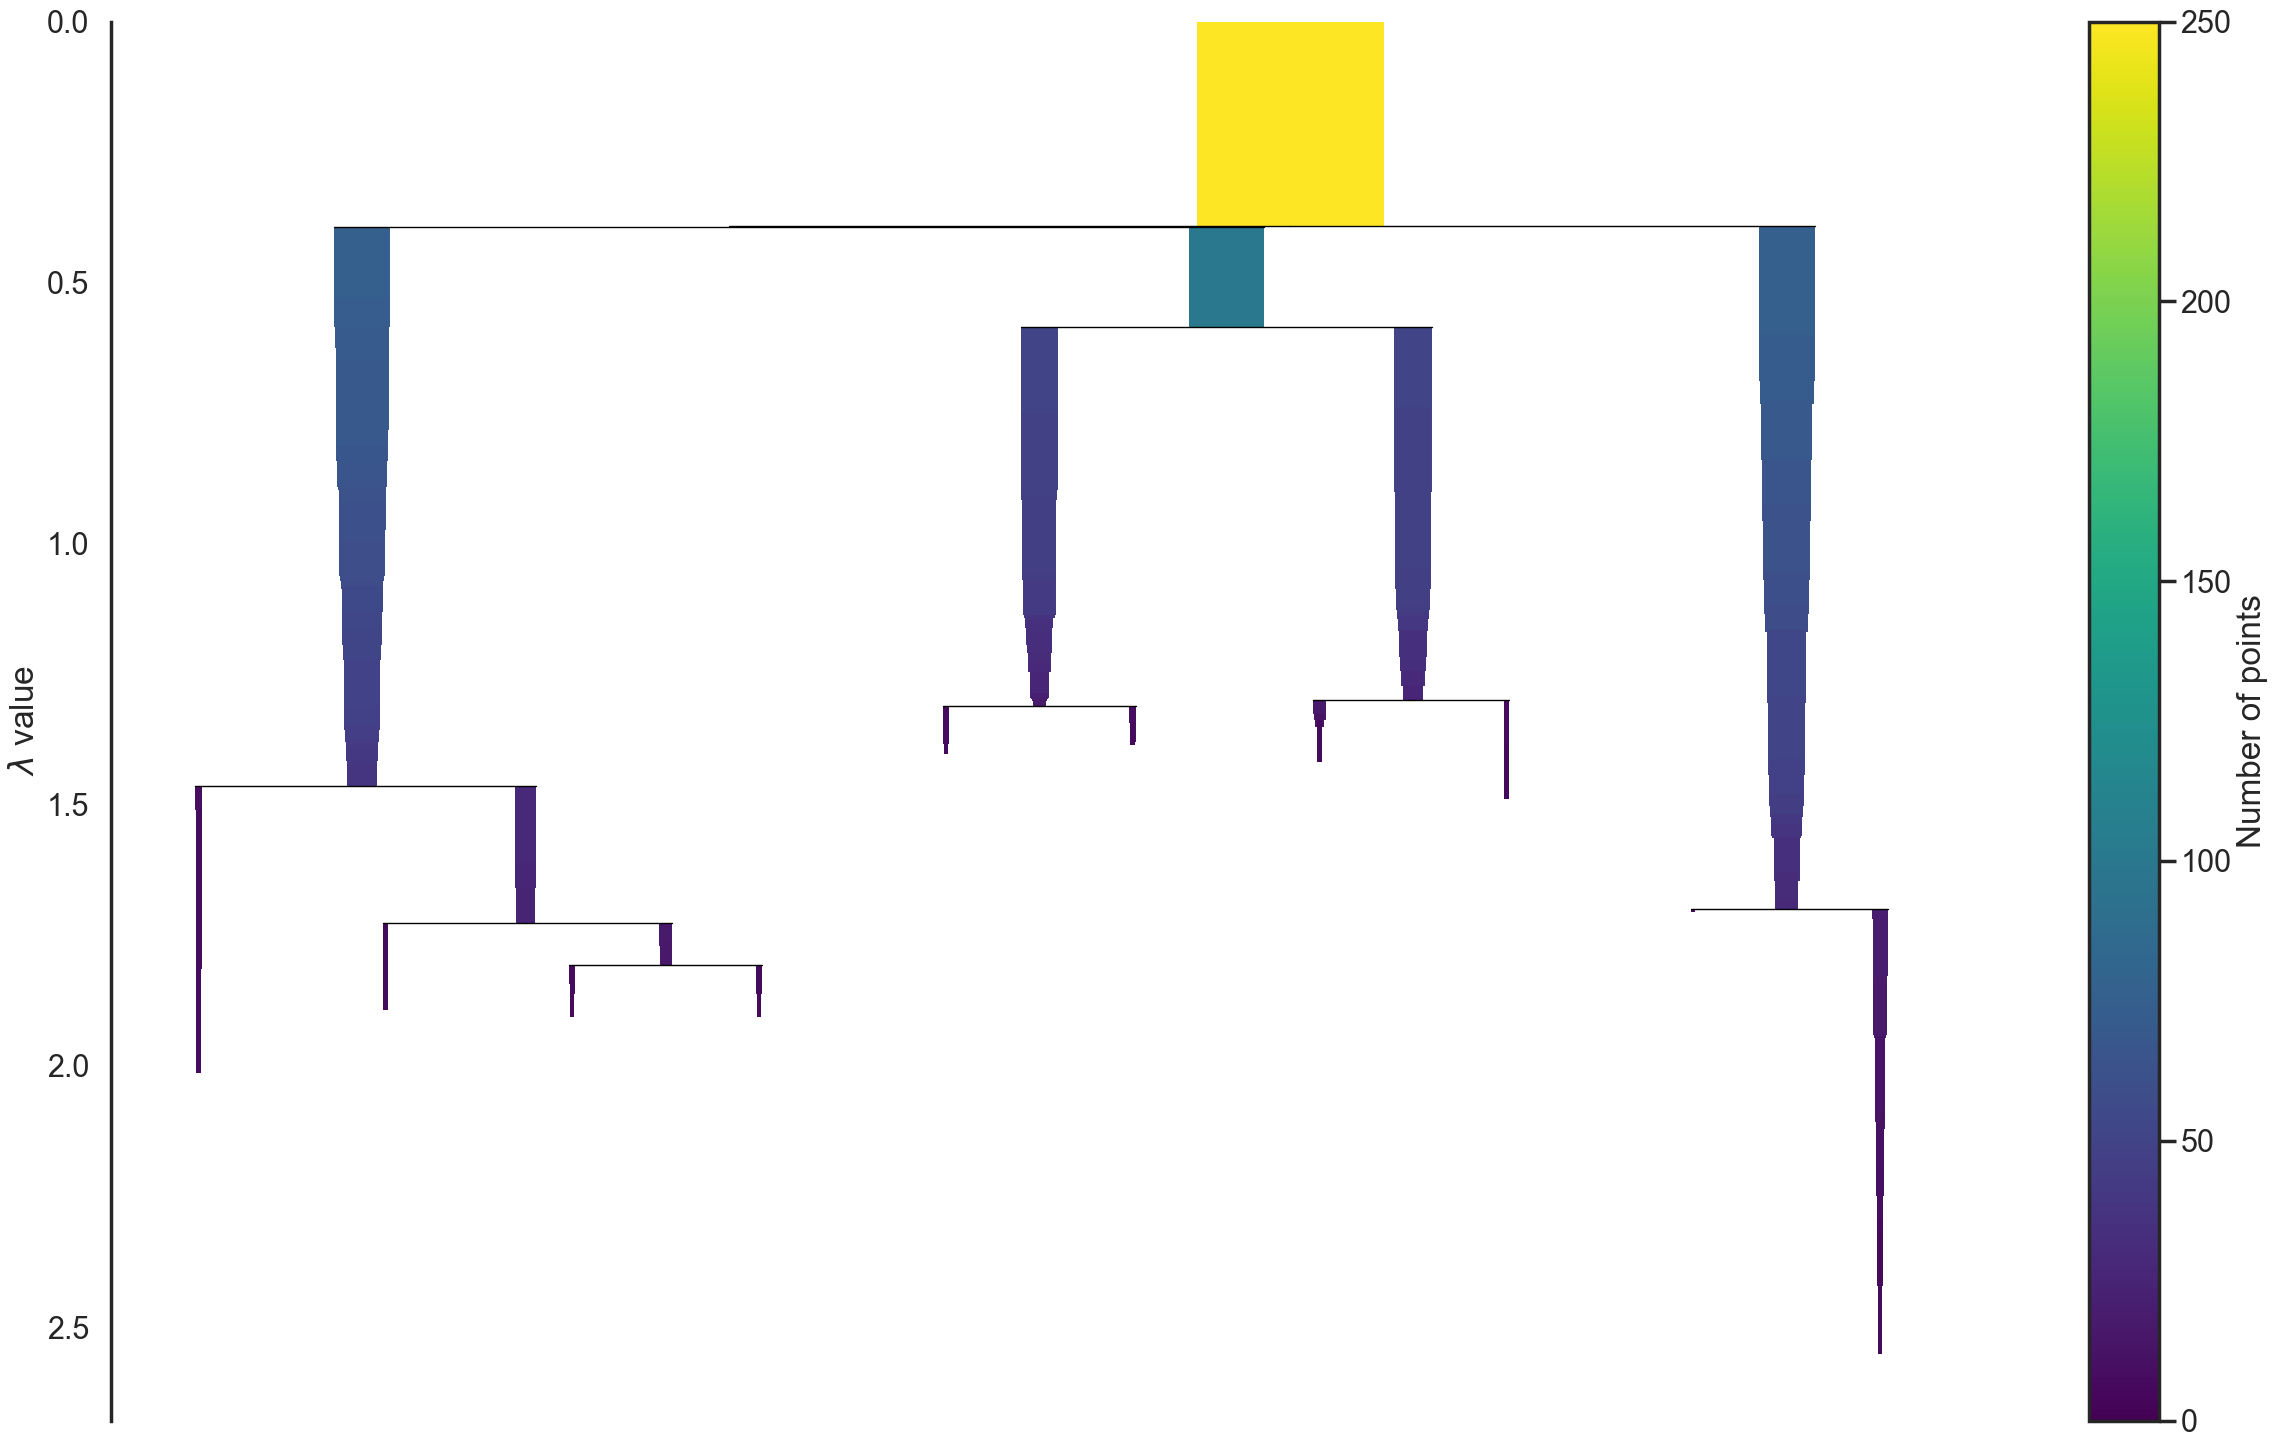

In [96]:
fig, ax = plt.subplots(figsize=(25, 15))
clusterer.condensed_tree_.plot()
plt.tight_layout()
plt.show()


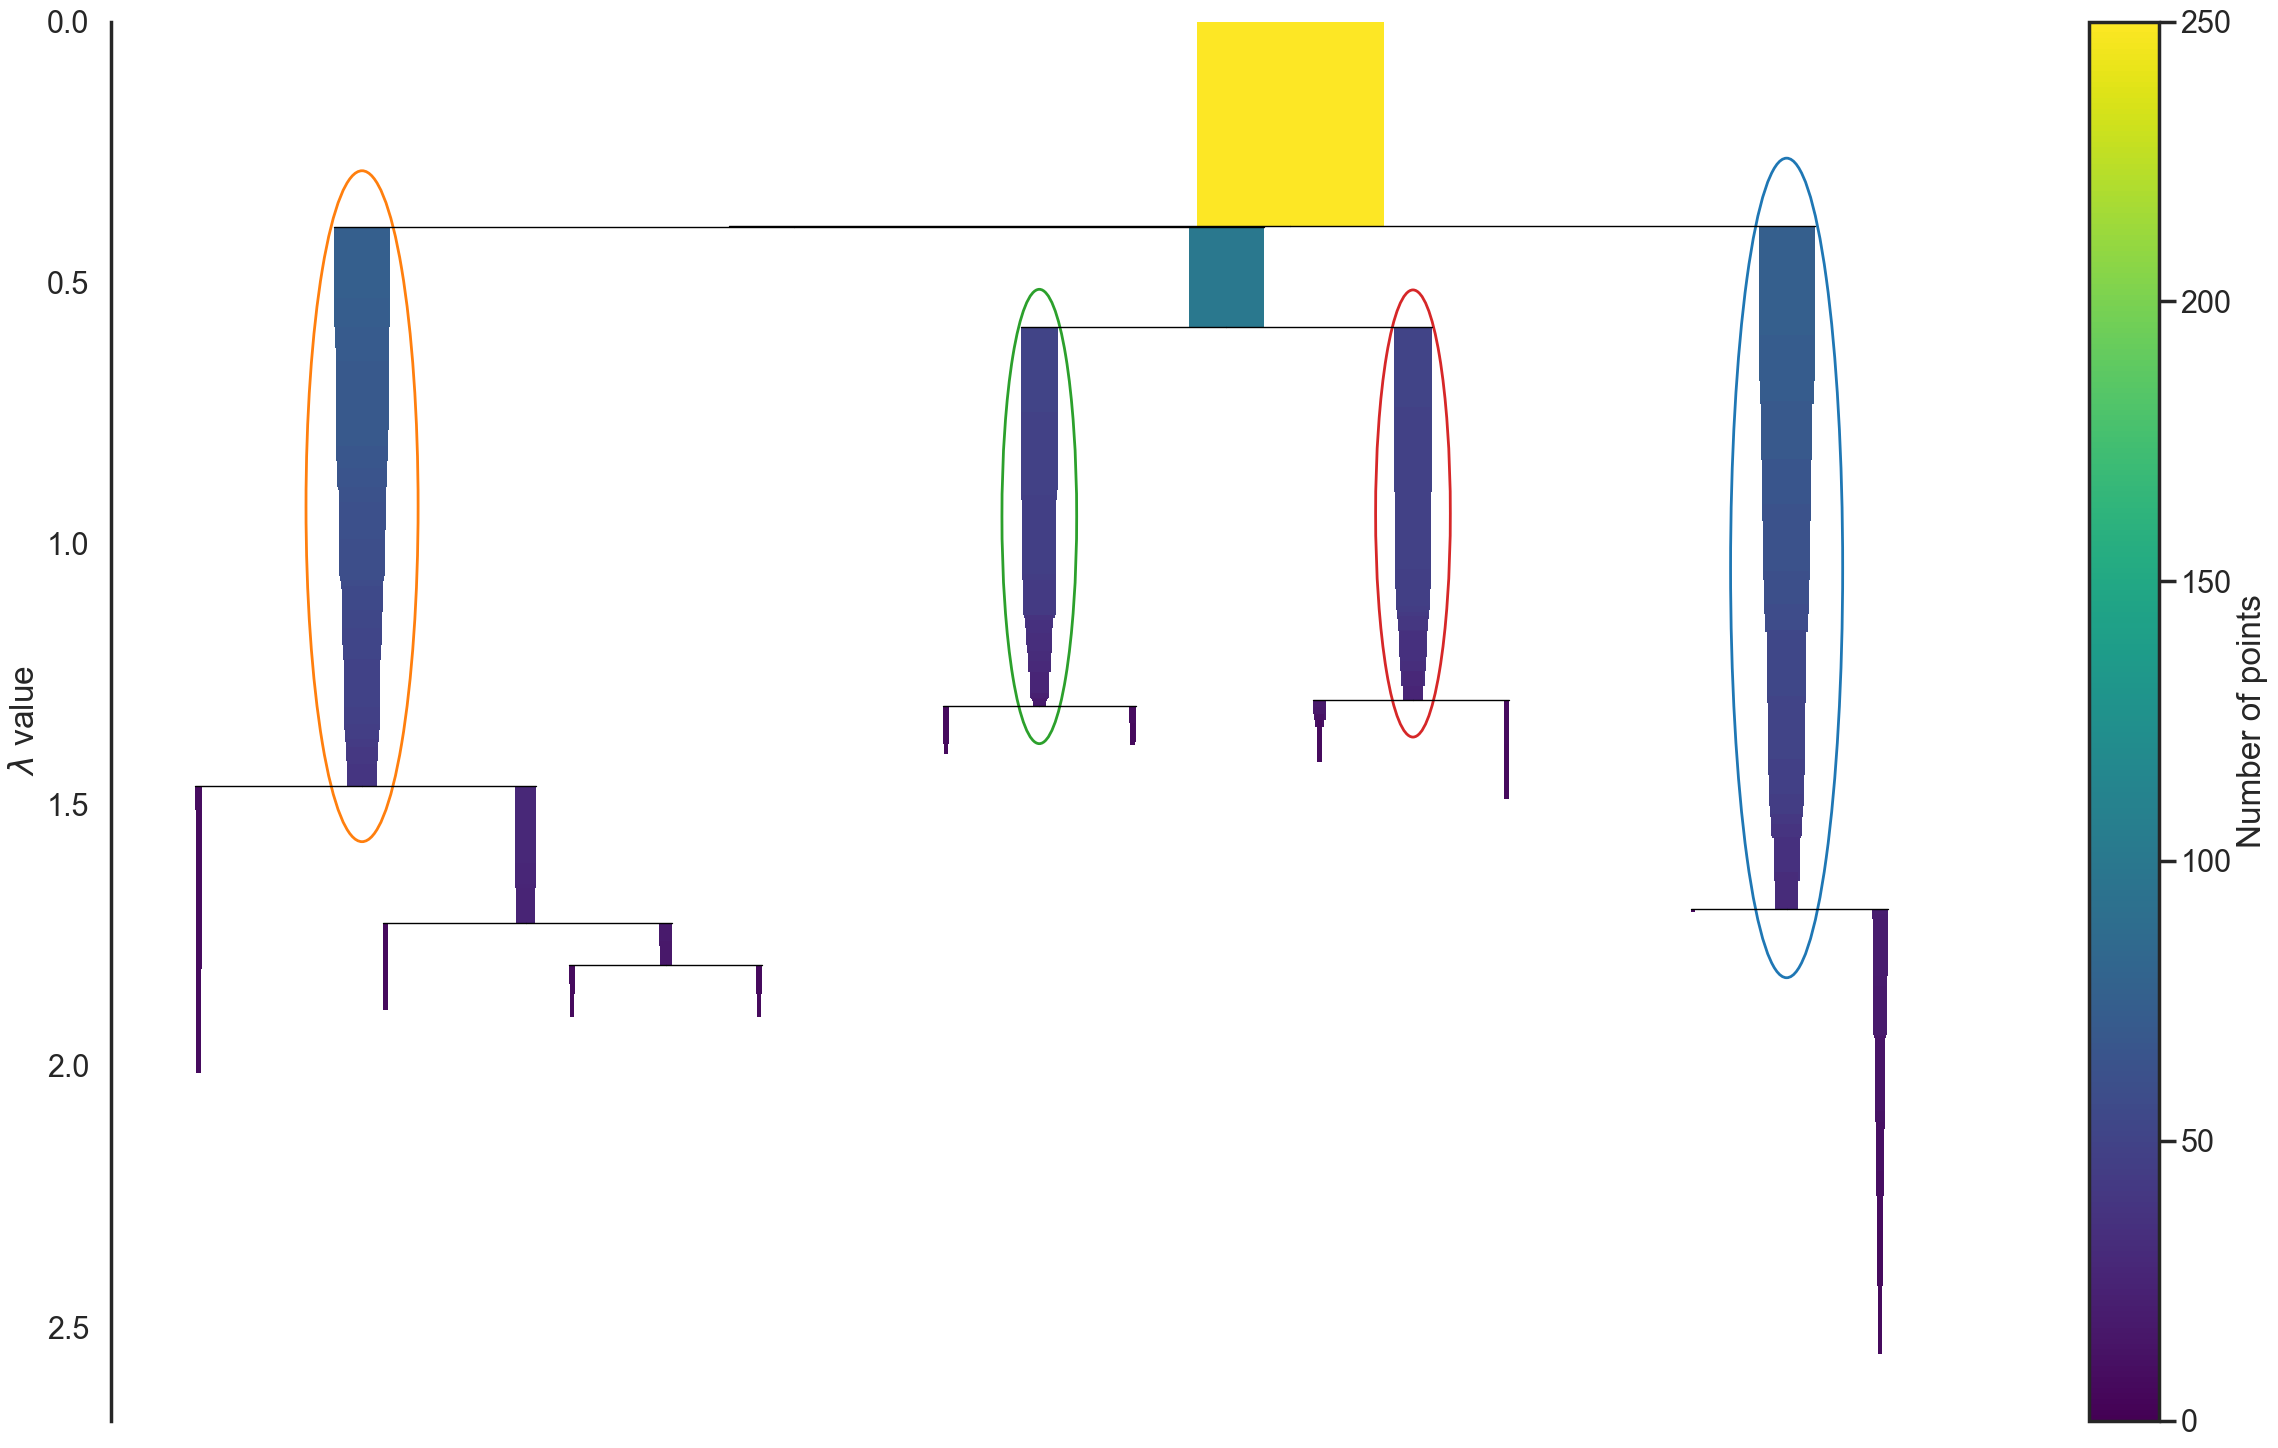

In [104]:
fig, ax = plt.subplots(figsize=(25, 15))
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
plt.tight_layout()
plt.show()


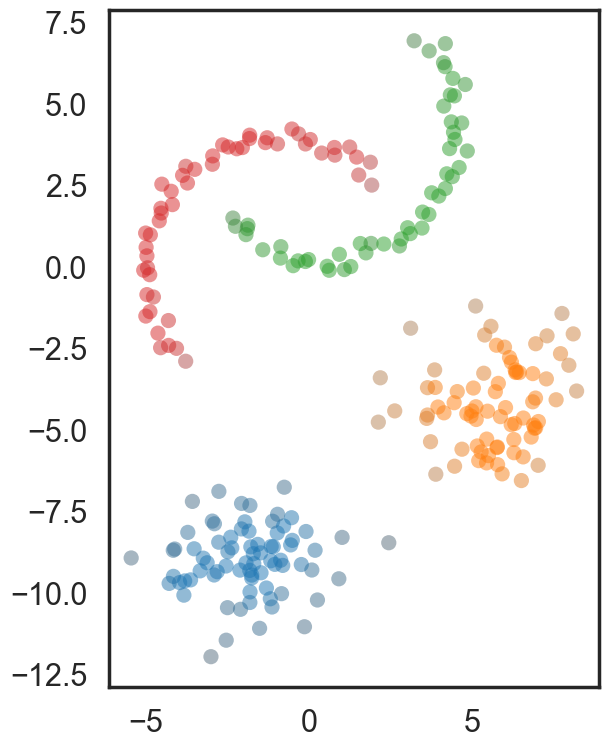

In [98]:
palette = sns.color_palette()
fig, ax = plt.subplots(figsize=(10, 8))
cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                  zip(clusterer.labels_, clusterer.probabilities_)]
ax.scatter(test_data.T[0], test_data.T[1], c=cluster_colors, **plot_kwds)
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

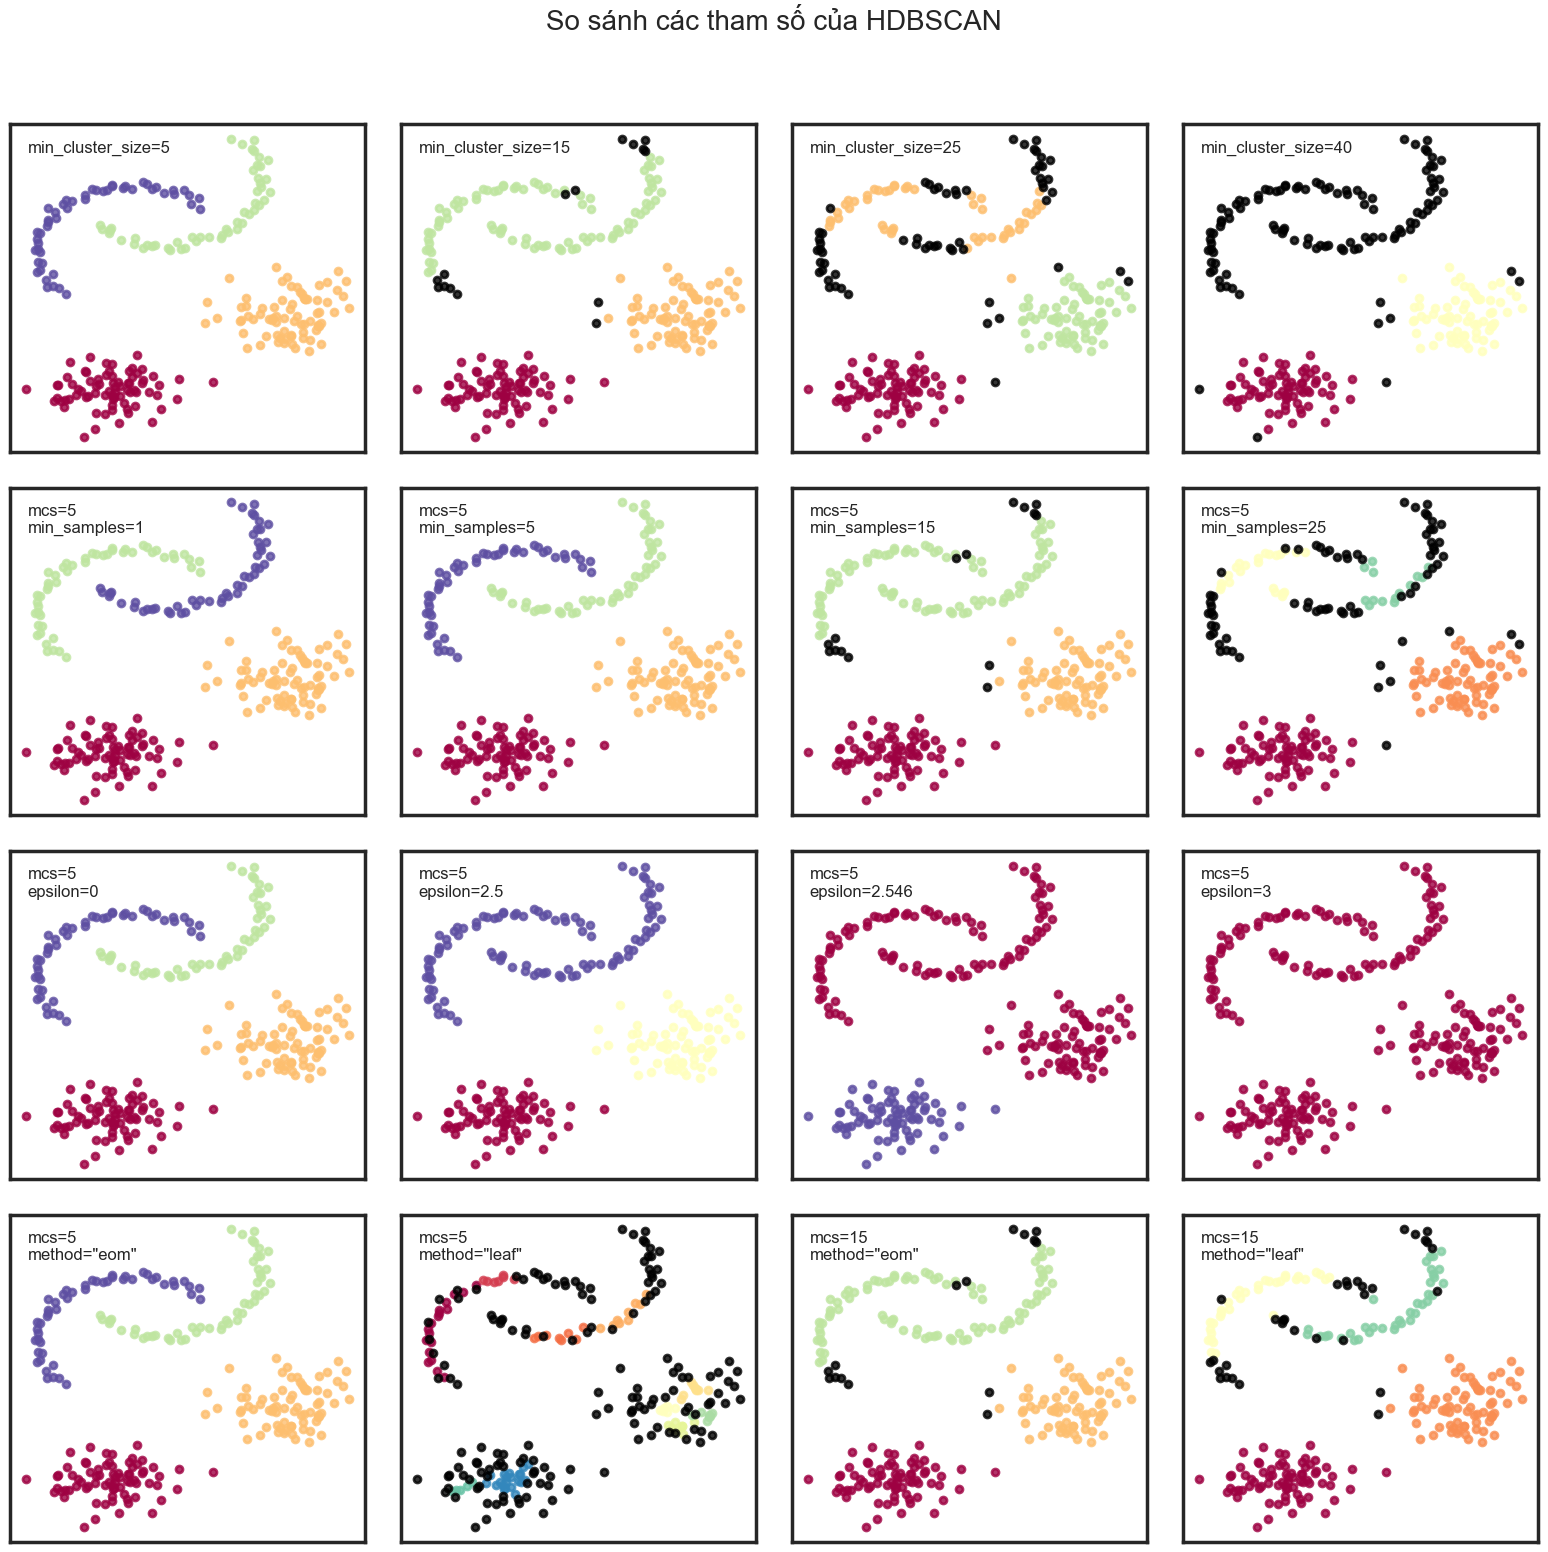

In [123]:
# Tạo một figure lớn chứa 4 hàng (mỗi hàng cho một tham số) và 4 cột
fig, axes = plt.subplots(4, 4, figsize=(16, 16), sharex=True, sharey=True)
plt.suptitle("So sánh các tham số của HDBSCAN", fontsize=20)

# Hàm trợ giúp để vẽ biểu đồ, tránh lặp code
def plot_clusters(ax, data, labels, text):
    unique_labels = set(labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Màu đen cho các điểm nhiễu (noise)
            col = [0, 0, 0, 0.5]
        
        class_member_mask = (labels == k)
        xy = data[class_member_mask]
        ax.scatter(xy[:, 0], xy[:, 1], c=[col], s=25, alpha=0.8)
        
    ax.text(0.05, 0.95, text, 
            transform=ax.transAxes, fontsize=12, verticalalignment='top')
    ax.set_xticks([])
    ax.set_yticks([])

# CASE 1: Thay đổi `min_cluster_size` 
min_cluster_sizes = [5, 15, 25, 40]
for i, size in enumerate(min_cluster_sizes):
    ax = axes[0, i]
    clusterer = hdbscan.HDBSCAN(min_cluster_size=size)
    clusterer.fit(test_data)
    plot_clusters(ax, test_data, clusterer.labels_, f'min_cluster_size={size}')

# CASE 2: Thay đổi `min_samples`
# Cố định min_cluster_size= 5 để thấy rõ ảnh hưởng.
min_samples_list = [1, 5, 15, 25]
for i, samples in enumerate(min_samples_list):
    ax = axes[1, i]
    clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=samples)
    clusterer.fit(test_data)
    plot_clusters(ax, test_data, clusterer.labels_, f'mcs=5\nmin_samples={samples}')

# CASE 3: Thay đổi `cluster_selection_epsilon`
# Cố định min_cluster_size=5.
epsilons = [0, 2.5, 2.546, 3]
for i, eps in enumerate(epsilons):
    ax = axes[2, i]
    clusterer = hdbscan.HDBSCAN(min_cluster_size=5, cluster_selection_epsilon=eps, allow_single_cluster=True)
    clusterer.fit(test_data)
    plot_clusters(ax, test_data, clusterer.labels_, f'mcs=5\nepsilon={eps}')

# --- CASE 4: Thay đổi `cluster_selection_method` ---
# So sánh 'eom' và 'leaf' với 2 giá trị min_cluster_size khác nhau
methods = ['eom', 'leaf']
mcs_for_method_test = [5, 15]

# Cột 0, 1: So sánh với mcs=5
ax_eom_1 = axes[3, 0]
clusterer_eom_1 = hdbscan.HDBSCAN(min_cluster_size=mcs_for_method_test[0], cluster_selection_method='eom')
clusterer_eom_1.fit(test_data)
plot_clusters(ax_eom_1, test_data, clusterer_eom_1.labels_, f'mcs={mcs_for_method_test[0]}\nmethod="eom"')

ax_leaf_1 = axes[3, 1]
clusterer_leaf_1 = hdbscan.HDBSCAN(min_cluster_size=mcs_for_method_test[0], cluster_selection_method='leaf')
clusterer_leaf_1.fit(test_data)
plot_clusters(ax_leaf_1, test_data, clusterer_leaf_1.labels_, f'mcs={mcs_for_method_test[0]}\nmethod="leaf"')

# Cột 2, 3: So sánh với mcs=40
ax_eom_2 = axes[3, 2]
clusterer_eom_2 = hdbscan.HDBSCAN(min_cluster_size=mcs_for_method_test[1], cluster_selection_method='eom')
clusterer_eom_2.fit(test_data)
plot_clusters(ax_eom_2, test_data, clusterer_eom_2.labels_, f'mcs={mcs_for_method_test[1]}\nmethod="eom"')

ax_leaf_2 = axes[3, 3]
clusterer_leaf_2 = hdbscan.HDBSCAN(min_cluster_size=mcs_for_method_test[1], cluster_selection_method='leaf')
clusterer_leaf_2.fit(test_data)
plot_clusters(ax_leaf_2, test_data, clusterer_leaf_2.labels_, f'mcs={mcs_for_method_test[1]}\nmethod="leaf"')


plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()